<a href="https://colab.research.google.com/github/dribnet/clipit/blob/future/demos/Start_Here.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIPIT demo

**Note:** Quick demo of basic functionality.

In [1]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!git clone https://github.com/openai/CLIP
# !pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!rm -Rf clipit
!git clone https://github.com/dribnet/clipit
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops
!pip install torch-optimizer
!pip install easydict
!pip install braceexpand
!mkdir steps
!wget https://user-images.githubusercontent.com/945979/126260797-adc60317-9518-40de-8700-b1f93e81e0ec.png -O this_is_fine.png
!wget https://user-images.githubusercontent.com/945979/126415385-d70ff2b0-f021-4238-9621-6180d33b242c.jpg -O perfume.jpg

In [3]:
#@title Download rendering models (VQGAN)

#@markdown #@title Selection of models to download
#@markdown By default, the notebook downloads the 1024 and 16384 models from ImageNet. There are others like COCO-Stuff, WikiArt 1024, WikiArt 16384, FacesHQ or S-FLCKR, which are heavy, and if you are not going to use them it would be pointless to download them, so if you want to use them, simply select the models to download.
#@markdown (you can return to this cell later and download more)

imagenet_1024 = False #@param {type:"boolean"}
imagenet_16384 = True #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_1024 = False #@param {type:"boolean"}
wikiart_16384 = False #@param {type:"boolean"}
sflckr = False #@param {type:"boolean"}
openimages_8192 = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_1024.yaml' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_1024.ckpt'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.yaml' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.ckpt' #ImageNet 16384
if openimages_8192:
  !curl -L -o vqgan_openimages_f16_8192.yaml -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_openimages_f16_8192.ckpt -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_1024: 
  !curl -L -o wikiart_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart.yaml' #WikiArt 1024
  !curl -L -o wikiart_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart.ckpt' #WikiArt 1024
if wikiart_16384: 
  !curl -L -o wikiart_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart_16384.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart_16384.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR


** Resuming transfer from byte position 692
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   692    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 980092370
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  934M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [8]:
#@title Settings for your run

#@markdown Here are the settings

#@markdown For now we'll just enter a text prompt!

#@title Parameters
prompts = "A boat on a river with tangerine trees and marmalade skies" #@param {type:"string"}

#@markdown and you can enter one or more clip models separated by commas

clip_models = "ViT-B/32, ViT-B/16" #@param {type:"string"}


#@markdown Width and height. Start small, work up.

width =  400 #@param {type:"number"}
height = 225 #@param {type:"number"}

#@markdown This should match what you downloaded above

model = "vqgan_imagenet_f16_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "vqgan_openimages_f16_8192", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]

############# SETUP WITH THESE SETTINGS

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 'vqgan_openimages_f16_8192':'OpenImages 8912',
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
name_model = model_names[model]     

# Simple setup
from clipit import generate
import easydict

args = easydict.EasyDict({
    "prompts": prompts,
    "clip_models": clip_models,
    "vqgan_config": f'{model}.yaml',
    "vqgan_checkpoint": f'{model}.ckpt',
    "display_freq": 50,
    "max_iterations": 300,
    "size": [width, height],
    "init_noise": "pixels"
})

vq_parser = generate.setup_parser()
settings = generate.process_args(vq_parser, namespace=args)
generate.do_init(settings)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['A boat on a river with tangerine trees and marmalade skies']
Using seed: 13297478178061867472


i: 0, loss: 1.88592, losses: 0.93466, 0.95126


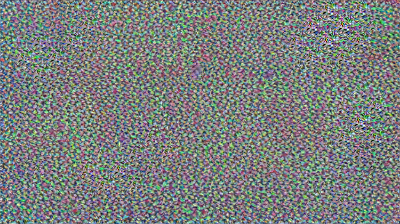

i: 50, loss: 1.57799, losses: 0.785733, 0.792257


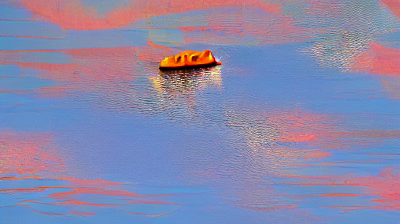

i: 100, loss: 1.5184, losses: 0.763722, 0.754683


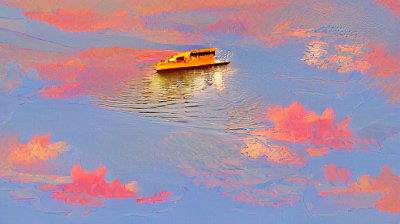

i: 150, loss: 1.49211, losses: 0.748559, 0.743551


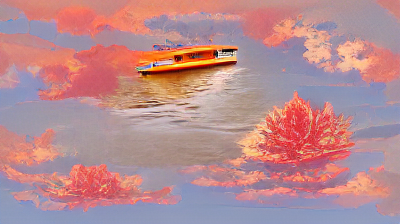

i: 200, loss: 1.42638, losses: 0.714278, 0.712105


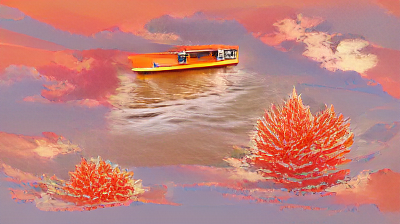

i: 250, loss: 1.39013, losses: 0.692435, 0.69769


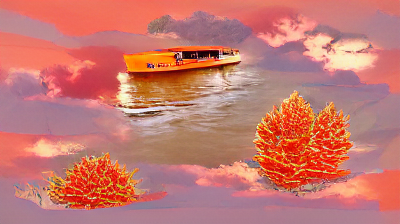

i: 300, loss: 1.41081, losses: 0.712739, 0.698073


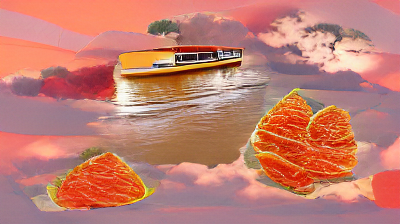

In [9]:
#@title Run

#@markdown Running with the settings used above


from IPython import display
generate.do_run(settings)
if settings.overlay_every is not None:
  print("Final version with overlay")
  display.display(display.Image("overlaid.png"))